In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LassoCV, Lasso
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import time

In [2]:
# remove unrelated columns
drop_columns = ['id', 'member_id', 'funded_amnt', 'funded_amnt_inv', 'loan_status', 'url', 'desc', 
               'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
               'recoveries',  'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d',
                 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low','policy_code', 
                'application_type', 'disbursement_method', 'debt_settlement_flag',  'debt_settlement_flag_date',
                'settlement_status',  'settlement_date', 'settlement_amount', 'settlement_percentage', 
                'settlement_term', 'sec_app_inq_last_6mths', 'orig_projected_additional_accrued_interest', 
                'payment_plan_start_date','deferral_term', 'total_rec_int', 'zip_code', 'title', 'pymnt_plan',
               'addr_state', 'emp_title']

In [3]:
print("Reading...")
start = time.time()
accepted = pd.read_csv('accepted_2007_to_2018Q4.csv', nrows=10000, low_memory=False)
pd.set_option('display.max_columns', 999)
accepted.head()
print("Took {:.2f} seconds".format(time.time() - start))

Reading...
Took 0.11 seconds


### Missing Values

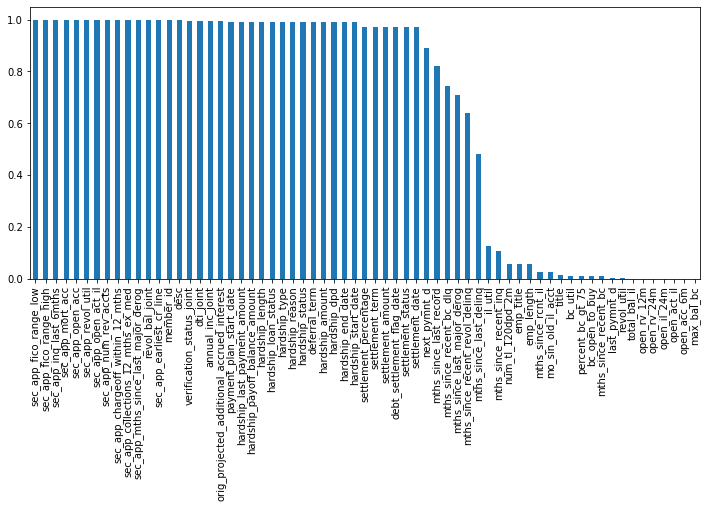

In [4]:
accepted.isna().mean().sort_values(ascending=False).head(65).plot(kind='bar', figsize=(12,5))

Majority of variables related to joint applications are NAN. Therefore, we create a dummy variable for joint application and remove all variables for joint application as most values are NAN.

In [5]:
accepted['isjoint'] = 1*(~accepted['sec_app_fico_range_high'].isna())

In [6]:
sec_columns = accepted.columns[accepted.columns.str.contains('sec_app')]
sec_columns = np.hstack((sec_columns, accepted.columns[accepted.columns.str.contains('_joint')]))
accepted.drop(columns = sec_columns, inplace=True)
sec_columns

array(['sec_app_fico_range_low', 'sec_app_fico_range_high',
       'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths',
       'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util',
       'sec_app_open_act_il', 'sec_app_num_rev_accts',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med',
       'sec_app_mths_since_last_major_derog', 'annual_inc_joint',
       'dti_joint', 'verification_status_joint', 'revol_bal_joint'],
      dtype=object)

Similarly for hardship variables. Most applicant didn't have hardship status. We create a dummy to refelct whether a person had hardship before or not and remove the hardship related columns

In [7]:
accepted['ishardship'] = 1*(~accepted['hardship_end_date'].isna())

In [8]:
hard_columns = accepted.columns[accepted.columns.str.contains('hardship_')]
accepted.drop(columns = hard_columns, inplace=True)
hard_columns

Index(['hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status',
       'hardship_amount', 'hardship_start_date', 'hardship_end_date',
       'hardship_length', 'hardship_dpd', 'hardship_loan_status',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount'],
      dtype='object')

For the remaining variables, we replace NaN values with zero

In [9]:
accepted = accepted.fillna(0)

### Data Type

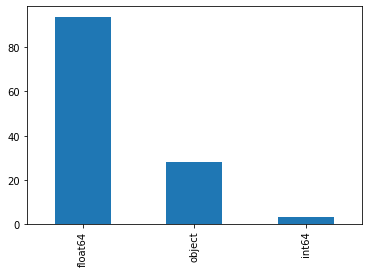

In [10]:
accepted.dtypes.value_counts().plot(kind='bar');

### Data Cleaning

Convert employement length from string to numeric by extracting numbers

In [11]:
accepted['emp_length'] = accepted['emp_length'].str.extract('(\d+)')[0].fillna(0).astype(int)

Extract the year from earliest_cr_line

In [12]:
accepted['earliest_cr_line'] = accepted['earliest_cr_line'].str.extract('(\d+)')[0].fillna(2018).astype(int)

Extract the year from issue_d

In [13]:
accepted['issue_d'] = accepted['issue_d'].str.extract('(\d+)')[0].fillna(2018).astype(int)

### EDA

Distribution of interest rate, majority of loan have interest rate between 7% to 15%

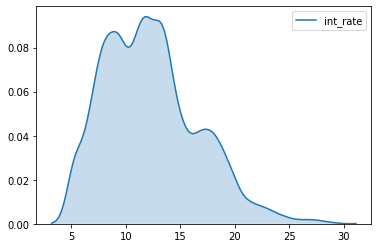

In [14]:
sns.kdeplot(accepted['int_rate'], shade=True)

Correlation between target and numeric columns

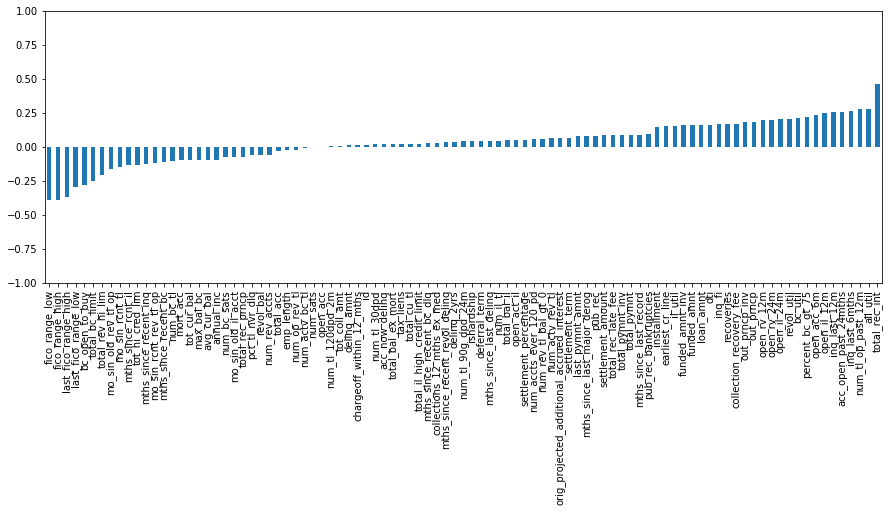

In [15]:
accepted.drop(columns=['int_rate']).corrwith(accepted['int_rate']).\
            sort_values().dropna().plot(kind='bar', figsize=(15,5))
plt.ylim([-1, 1]);

Among features, Fico scores and the number of accounts opened in past 12 months have the highest correlation with the target. Fico score has negative correlation which means that higher Fico score leads to lower interest rate. On the other hand, number of account has positive correlation which means that if a person has opened many account during the last 12 months, his interest rate would be higher

This figure shows that longer loan duration leads to higher insterest rate

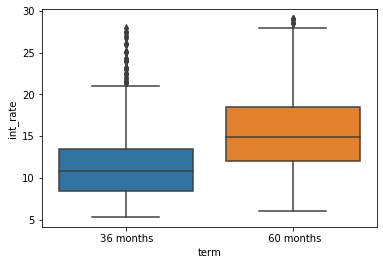

In [16]:
sns.boxplot(x='term', y='int_rate', data=accepted);

Lending club uses a model to assing borrower a grade based on their profile. Grade A has the lowest risk for the investor and grade G has the highest. Below figure shows that the interest rate is highly correlated with borower grade

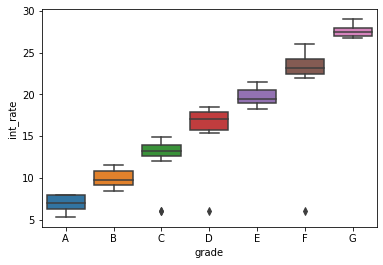

In [17]:
sns.boxplot(x='grade', y='int_rate', data=accepted.sort_values('grade'));

This figure shows the correlation between loan amount and interest rate. Higher loan amounts tend to have higher interest rate

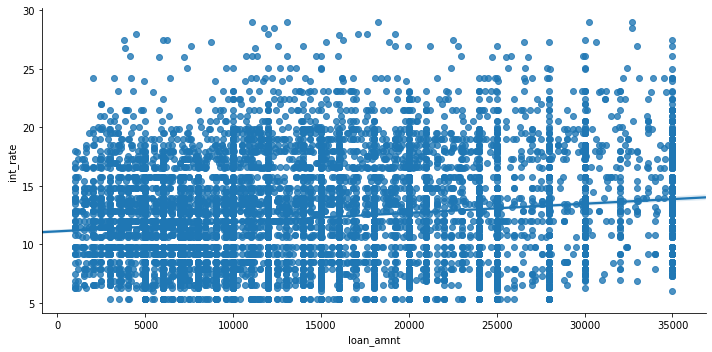

In [18]:
sns.lmplot(x='loan_amnt', y='int_rate', data=accepted,height=5, aspect=2)

FICO score is impacting interest rate for the borower. Better FICO score (higher values) leads to lower interest rate

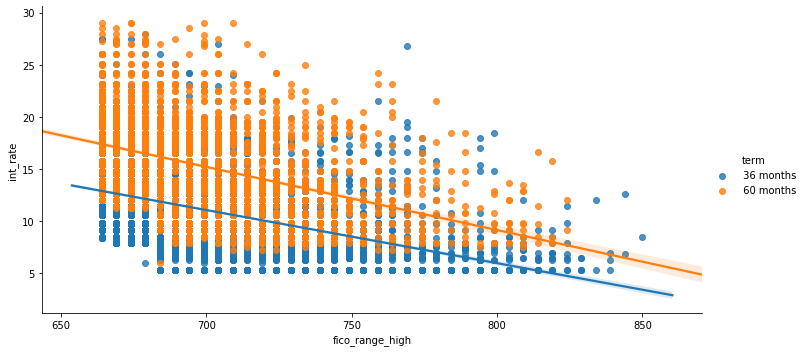

In [19]:
sns.lmplot(x='fico_range_high', y='int_rate', hue='term', data=accepted,height=5, aspect=2)

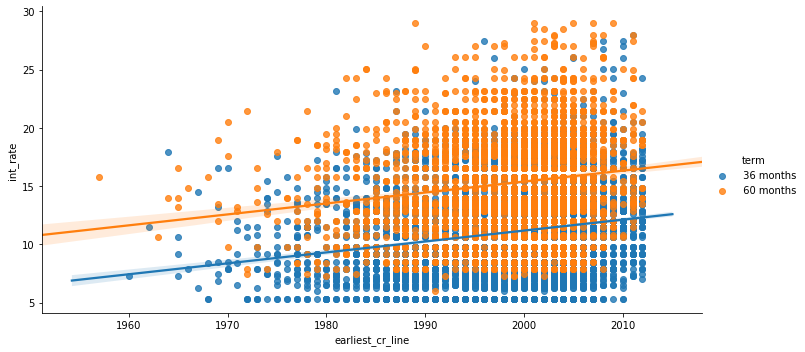

In [20]:
sns.lmplot(x='earliest_cr_line', y='int_rate', hue='term', data=accepted,height=5, aspect=2)

Interest Rate versus year, the interest rate is also a function of nationwide economy which varies over time

/home/arliss/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempting to set identical left == right == 2015.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


([<matplotlib.axis.XTick at 0x7f9c6863ffd0>],
 <a list of 1 Text xticklabel objects>)

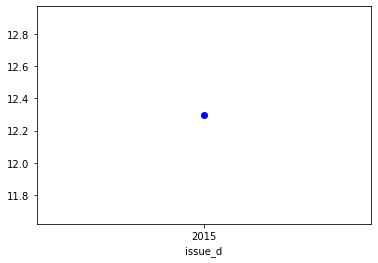

In [21]:
accepted.groupby('issue_d')['int_rate'].mean().plot(style='bo-')
plt.xticks(accepted['issue_d'].unique())

The following figure shows the interest rate for different loan purpose. It shows that certain loan purpose has lower interest rate such as buying a car due to lower risk to the investors

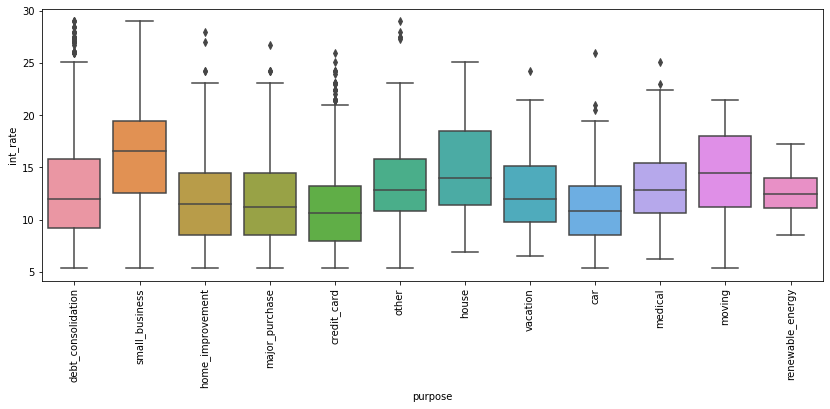

In [22]:
plt.figure(figsize=(14,5))
sns.boxplot(x='purpose', y='int_rate', data=accepted);
plt.xticks(rotation=90);

In the following figure the distirbution of interest rate for different home ownership status is depicted. Borrowers who are renting tend to have higher interest rate on their loan application. This is due to the fact that home owners (or people with mortgage) carry less task to the investors, as their home can be later used as a collateral to repay the loan

Text(0, 0.5, 'Distribution')

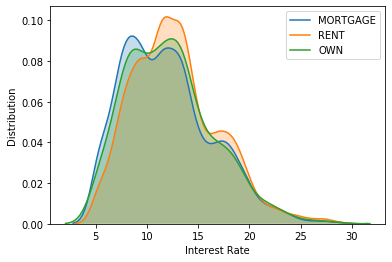

In [23]:
for item in accepted['home_ownership'].unique():
    sns.kdeplot(accepted[accepted['home_ownership'] == item]['int_rate'], label = item, shade=True)
plt.xlabel('Interest Rate')
plt.ylabel('Distribution')

## Modeling

In [24]:
accepted = accepted.drop(columns=['grade', 'sub_grade', 'installment'])

In [25]:
print("Reading...")
start = time.time()
accepted_dummy = pd.get_dummies(accepted)
X_train = accepted_dummy.drop(columns='int_rate')
print("Took {:.2f} seconds".format(time.time() - start))

Reading...
Took 0.52 seconds


In [26]:
print("Reading...")
start = time.time()
scaler = StandardScaler()
X = scaler.fit_transform(X_train)
y = accepted_dummy['int_rate'].values
print(X.shape)
print("Took {:.2f} seconds".format(time.time() - start))

Reading...
(10000, 16773)
Took 3.34 seconds


### Outlier Detection Using Linear Regression

We fit a linear regression model on the selected features and then caluclate the residual for each observation on the dataset. The residuals versus fitted values are plotted and outliers are idenitfied. Below figure shows that there is one outlier in our dataset. It also shows that there is a non-linear trend in the residuals which is not captured by the linear model. Therefore, we expect that the linear model does not perform well in this problem

In [ ]:
print("Reading...")
start = time.time()
lin = LinearRegression()
lin.fit(X, y);
fitted = lin.predict(X)
res = y - fitted
outlier = abs(res) > 15
plt.plot(fitted, res, 'ko', alpha = 0.1)
plt.plot(fitted[outlier], res[outlier], 'ro')
plt.xlabel('Fitted Value')
plt.ylabel('Residual');
print("Took {:.2f} seconds".format(time.time() - start))

Outliers are removed from the dataset

In [ ]:
print("Reading...")
start = time.time()
X = X[~outlier,:]
y = y[~outlier]
print("Took {:.2f} seconds".format(time.time() - start))

### Linear Regression Feature Selection

We use stepwise feature selection with cross-validation and a linear regression model

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=123)
lin = LinearRegression()
rfecv = RFECV(estimator=lin, step=1, cv=kf, scoring='neg_mean_squared_error')
rfecv.fit(X, y)

In [ ]:
print("Reading...")
start = time.time()
selected = rfecv.get_support()
indx = np.argmin(-rfecv.grid_scores_)

plt.plot(range(1, len(rfecv.grid_scores_) + 1), -rfecv.grid_scores_, 'bo-')
plt.plot(range(1, len(rfecv.grid_scores_) + 1)[indx], -rfecv.grid_scores_[indx], 'ro')
plt.yscale('log')
plt.xlabel('Number of Features')
plt.ylabel('RMSE');
print("Took {:.2f} seconds".format(time.time() - start))

Stepwise feature selection has selected 70 features with the lowest RMSE

In [ ]:
print('hello')

In [ ]:
selected.sum()

### Lasso Feature Selection

In [ ]:
print("Reading...")
start = time.time()
lasso_cv = LassoCV(cv=10, random_state=123, max_iter = 400, tol =1e-2)
lasso_cv.fit(X,y);
print("Took {:.2f} seconds".format(time.time() - start))

In [ ]:
print("Reading...")
start = time.time()
lasso_mse = lasso_cv.mse_path_.mean(axis=1)
plt.plot(lasso_cv.alphas_, lasso_mse, 'b-')
plt.plot(lasso_cv.alphas_[lasso_mse.argmin()], lasso_mse[lasso_mse.argmin()], 'ro')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('MSE');
plt.title('Optimal Lasso: {0:.3f}'.format(lasso_cv.alphas_[lasso_mse.argmin()]));
print("Took {:.2f} seconds".format(time.time() - start))

In [ ]:
print("Reading...")
start = time.time()
lasso = Lasso(alpha = lasso_cv.alphas_[lasso_mse.argmin()])
lasso.fit(X,y);
selected_lasso = np.abs(lasso.coef_) > 0.1
lasso_df = pd.Series(lasso.coef_[selected_lasso], index=X_train.columns[selected_lasso])
lasso_df.sort_values().plot(kind='bar', figsize=(15,5));
print("Took {:.2f} seconds".format(time.time() - start))

### Random Forest Feature Importance

In [ ]:
print("Reading...")
start = time.time()
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X,y)
imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
imp.head(50).plot(kind='bar', figsize=(15,5));
print("Took {:.2f} seconds".format(time.time() - start))

### Cross Validation and Model Selection

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=123)

In [ ]:
gb = GradientBoostingRegressor(n_estimators=100, max_depth=8)
gb_scores = cross_val_score(gb, X, y, cv=kf, scoring='r2')

In [ ]:
rf = RandomForestRegressor(n_estimators=100)
rf_scores = cross_val_score(rf, X, y, cv=kf, scoring='r2')

In [ ]:
lin = LinearRegression()
lin_scores = cross_val_score(lin, X[:,selected], y, cv=kf, scoring='r2')

In [ ]:
svr = SVR(gamma='auto')
svr_scores = cross_val_score(svr, X[:,selected], y, cv=kf, scoring='r2')

In [ ]:
tree = DecisionTreeRegressor()
tree_scores = cross_val_score(tree, X, y, cv=kf, scoring='r2')

In [ ]:
lasso = Lasso(alpha = lasso_cv.alphas_[lasso_mse.argmin()])
lasso_scores = cross_val_score(tree, X, y, cv=kf, scoring='r2')

In [ ]:
res = pd.DataFrame({'gb': gb_scores, 'rf': rf_scores, 'lin': lin_scores, 'svr': svr_scores, 
                    'tree': tree_scores, 'lasso': lasso_scores})
res

In [ ]:
sns.barplot(x="model", y="r2", data=res.melt(var_name='model', value_name='r2'));

### Model Optimization

From above cross-validation, we can se Gradient Boosting has the highest R2 value and outperforms other model. In the following section, we use grid search CV method to optimize the hyperparamteres of the Gradient Boosting model and improve its performance

In [ ]:
params = {'n_estimators': [100, 150, 200],
          'max_depth': [4, 6, 8],
          'max_features': ['sqrt', 'log2']}
gb = GradientBoostingRegressor(random_state = 123)
grid = GridSearchCV(gb, params, cv=3, n_jobs=4, scoring='r2')
grid.fit(X,y);
grid.best_estimator_

In [ ]:
gb_scores = cross_val_score(grid.best_estimator_, X, y, cv=kf, scoring='r2')
print('Best Model R2: {0:.2f} +- {1:.2f}'.format(gb_scores.mean(), gb_scores.std()))

The GB with 200 estimators, max_depth of 4, max_feature of 'sqrt' has the optimal performance. The cross-validation shows the R2 of 0.65 which is better than our plain GB

In [27]:
## Converts categorical variables to dummy values

def category_onehot_multcols(multcolumns):
    df_final=dfcombined
    i=0
    for fields in multcolumns:
        
        print(fields)
        df1=pd.get_dummies(dfcombined[fields],drop_first=True)
        
        dfcombined.drop([fields],axis=1,inplace=True)
        if i==0:
            df_final=df1.copy()
        else:
            
            df_final=pd.concat([df_final,df1],axis=1)
        i=i+1
       
        
    df_final=pd.concat([dfcombined,df_final],axis=1)
        
    return df_final

In [28]:
features = pd.DataFrame(pd.get_dummies(accepted))

In [29]:
# Extract features and labels
labels = accepted['int_rate']
features = features.drop('int_rate', axis = 1)

In [30]:
# Convert to numpy arrays
import numpy as np

features = np.array(features)
labels = np.array(labels)

# Training and Testing Sets
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, 
                                                                            test_size = 0.25, random_state = 42)

In [31]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (7500, 16773)
Training Labels Shape: (7500,)
Testing Features Shape: (2500, 16773)
Testing Labels Shape: (2500,)


In [32]:
from sklearn.ensemble import RandomForestRegressor
print("Reading...")
start = time.time()
rf = RandomForestRegressor(random_state = 42)

from pprint import pprint

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())
print("Took {:.2f} seconds".format(time.time() - start))

Reading...
Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}
Took 0.00 seconds


In [33]:
from sklearn.model_selection import RandomizedSearchCV
print("Reading...")
start = time.time()
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)
print("Took {:.2f} seconds".format(time.time() - start))

Reading...
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
Took 0.00 seconds


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
print("Reading...")
start = time.time()
rf = RandomForestRegressor(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 10, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(train_features, train_labels);
print("Took {:.2f} seconds".format(time.time() - start))

Reading...
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 27.8min


In [ ]:
# save the model to disk
from sklearn.externals import joblib
import pickle

filename = 'finalized_RFmodel.sav'
pickle.dump(rf_random, open(filename, 'wb'))

In [ ]:
print('hello')